In [1]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

%matplotlib inline 

import _init_paths
import os
import sys
print(sys.version)
import warnings
warnings.filterwarnings("ignore")
import numpy as np
import argparse
import pprint
import pdb
import time
import cv2
import torch
from torch.autograd import Variable
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt

import torchvision.transforms as transforms
import torchvision.datasets as dset
from scipy.misc import imread

from model.utils.config import cfg, cfg_from_file, cfg_from_list, get_output_dir
from model.rpn.bbox_transform import clip_boxes
from model.nms.nms_wrapper import nms
from model.rpn.bbox_transform import bbox_transform_inv
from model.utils.net_utils import save_net, load_net, vis_detections
from model.utils.blob import im_list_to_blob
from model.faster_rcnn.vgg16 import vgg16
from model.faster_rcnn.resnet import resnet
from roi_data_layer.roidb import combined_roidb
from roi_data_layer.roibatchLoader import roibatchLoader
import pdb
torch.cuda.empty_cache()
try:
	xrange          # Python 2
except NameError:
	xrange = range  # Python 3

2.7.12 (default, Nov 12 2018, 14:36:49) 
[GCC 5.4.0 20160609]


In [2]:
def _get_image_blob(im):
    
    """
    Converts an image into a network input.
    Arguments:
    im (ndarray): a color image in BGR order
    Returns:
    blob (ndarray): a data blob holding an image pyramid
    im_scale_factors (list): list of image scales (relative to im) used
      in the image pyramid
    """
    im_orig = im.astype(np.float32, copy=True)
    im_orig -= cfg.PIXEL_MEANS

    im_shape = im_orig.shape
    im_size_min = np.min(im_shape[0:2])
    im_size_max = np.max(im_shape[0:2])

    processed_ims = []
    im_scale_factors = []

    for target_size in cfg.TEST.SCALES:
        im_scale = float(target_size) / float(im_size_min)
        # Prevent the biggest axis from being more than MAX_SIZE
        if np.round(im_scale * im_size_max) > cfg.TEST.MAX_SIZE:
            im_scale = float(cfg.TEST.MAX_SIZE) / float(im_size_max)
        im = cv2.resize(im_orig, None, None, fx=im_scale, fy=im_scale,
                interpolation=cv2.INTER_LINEAR)
        im_scale_factors.append(im_scale)
        processed_ims.append(im)

      # Create a blob to hold the input images
    blob = im_list_to_blob(processed_ims)

    return blob, np.array(im_scale_factors)

In [3]:
def process_image(im_in):
    
    torch.cuda.empty_cache()
    total_tic = time.time()
    if len(im_in.shape) == 2:
        im_in = im_in[:,:,np.newaxis]
        im_in = np.concatenate((im_in,im_in,im_in), axis=2)
    im_in = im_in[:,:,::-1]
    im = cv2.cvtColor(im_in, cv2.COLOR_RGB2BGR)

    blobs, im_scales = _get_image_blob(im)
    im_blob = blobs
    im_info_np = np.array([[im_blob.shape[1], im_blob.shape[2], im_scales[0]]], dtype=np.float32)

    im_data_pt = torch.from_numpy(im_blob)
    im_data_pt = im_data_pt.permute(0, 3, 1, 2)
    im_info_pt = torch.from_numpy(im_info_np)

    im_data.data.resize_(im_data_pt.size()).copy_(im_data_pt)
    im_info.data.resize_(im_info_pt.size()).copy_(im_info_pt)
    gt_boxes.data.resize_(1, 1, 5).zero_()
    num_boxes.data.resize_(1).zero_()

    det_tic = time.time()
    
    with torch.no_grad():
        rois, cls_prob, bbox_pred, \
        rpn_loss_cls, rpn_loss_box, \
        RCNN_loss_cls, RCNN_loss_bbox, \
        rois_label = fasterRCNN(im_data, im_info, gt_boxes, num_boxes)

        scores = cls_prob.data
        boxes = rois.data[:, :, 1:5]

        if cfg.TEST.BBOX_REG:
            box_deltas = bbox_pred.data
            if cfg.TRAIN.BBOX_NORMALIZE_TARGETS_PRECOMPUTED:
                box_deltas = box_deltas.view(-1, 4) * torch.FloatTensor(cfg.TRAIN.BBOX_NORMALIZE_STDS).cuda() \
                                       + torch.FloatTensor(cfg.TRAIN.BBOX_NORMALIZE_MEANS).cuda()
                box_deltas = box_deltas.view(1, -1, 4 * len(coco_classes))
            pred_boxes = bbox_transform_inv(boxes, box_deltas, 1)
            pred_boxes = clip_boxes(pred_boxes, im_info.data, 1)
        else:
            _ = torch.from_numpy(np.tile(boxes, (1, scores.shape[1])))
            pred_boxes = _.cuda()

        pred_boxes /= im_scales[0]

        scores = scores.squeeze()
        pred_boxes = pred_boxes.squeeze()
        det_toc = time.time()
        detect_time = det_toc - det_tic
        misc_tic = time.time()

        im2show = np.copy(im)
        cls_seen = []
        for j in xrange(1, len(coco_classes)):
            inds = torch.nonzero(scores[:,j]>thresh).view(-1)
            if inds.numel() > 0:
                cls_scores = scores[:,j][inds]
                _, order = torch.sort(cls_scores, 0, True)
                cls_boxes = pred_boxes[inds][:, j * 4:(j + 1) * 4]

                cls_dets = torch.cat((cls_boxes, cls_scores.unsqueeze(1)), 1)
                cls_dets = cls_dets[order]
                keep = nms(cls_dets, cfg.TEST.NMS, force_cpu=not cfg.USE_GPU_NMS)
                cls_dets = cls_dets[keep.view(-1).long()]
                im2show = vis_detections(im2show, coco_classes[j], cls_dets.cpu().numpy(), 0.5)
                cls_seen.append(cls_scores)

    return im2show, cls_seen

In [4]:
def process_frame(im_in):
    
    global total_time
    global total_frames
    
    total_tic = time.time()
    if len(im_in.shape) == 2:
        im_in = im_in[:,:,np.newaxis]
        im_in = np.concatenate((im_in,im_in,im_in), axis=2)
    im_in = im_in[:,:,::-1]
    im = cv2.cvtColor(im_in, cv2.COLOR_RGB2BGR)

    blobs, im_scales = _get_image_blob(im)
    im_blob = blobs
    im_info_np = np.array([[im_blob.shape[1], im_blob.shape[2], im_scales[0]]], dtype=np.float32)

    im_data_pt = torch.from_numpy(im_blob)
    im_data_pt = im_data_pt.permute(0, 3, 1, 2)
    im_info_pt = torch.from_numpy(im_info_np)

    im_data.data.resize_(im_data_pt.size()).copy_(im_data_pt)
    im_info.data.resize_(im_info_pt.size()).copy_(im_info_pt)
    gt_boxes.data.resize_(1, 1, 5).zero_()
    num_boxes.data.resize_(1).zero_()

    det_tic = time.time()
    
    with torch.no_grad():
        rois, cls_prob, bbox_pred, \
        rpn_loss_cls, rpn_loss_box, \
        RCNN_loss_cls, RCNN_loss_bbox, \
        rois_label = fasterRCNN(im_data, im_info, gt_boxes, num_boxes)

        det_toc = time.time()

        total_time += det_toc - det_tic

        scores = cls_prob.data
        boxes = rois.data[:, :, 1:5]

        if cfg.TEST.BBOX_REG:
            box_deltas = bbox_pred.data
            if cfg.TRAIN.BBOX_NORMALIZE_TARGETS_PRECOMPUTED:
                box_deltas = box_deltas.view(-1, 4) * torch.FloatTensor(cfg.TRAIN.BBOX_NORMALIZE_STDS).cuda() \
                                       + torch.FloatTensor(cfg.TRAIN.BBOX_NORMALIZE_MEANS).cuda()
                box_deltas = box_deltas.view(1, -1, 4 * len(coco_classes))
            pred_boxes = bbox_transform_inv(boxes, box_deltas, 1)
            pred_boxes = clip_boxes(pred_boxes, im_info.data, 1)
        else:
            _ = torch.from_numpy(np.tile(boxes, (1, scores.shape[1])))
            pred_boxes = _.cuda()

        pred_boxes /= im_scales[0]

        scores = scores.squeeze()
        pred_boxes = pred_boxes.squeeze()

        im2show = np.copy(im)
        cls_seen = []
        for j in xrange(1, len(coco_classes)):
            inds = torch.nonzero(scores[:,j]>thresh).view(-1)
            if inds.numel() > 0:
                cls_scores = scores[:,j][inds]
                _, order = torch.sort(cls_scores, 0, True)
                cls_boxes = pred_boxes[inds][:, j * 4:(j + 1) * 4]

                cls_dets = torch.cat((cls_boxes, cls_scores.unsqueeze(1)), 1)
                cls_dets = cls_dets[order]
                keep = nms(cls_dets, cfg.TEST.NMS, force_cpu=not cfg.USE_GPU_NMS)
                cls_dets = cls_dets[keep.view(-1).long()]
                im2show = vis_detections(im2show, coco_classes[j], cls_dets.cpu().numpy(), 0.5)
                cls_seen.append(coco_classes[j])

        total_frames +=1

    return im2show

In [7]:
if __name__ == '__main__':

    from moviepy.editor import VideoFileClip
    cfg_from_file('cfgs/res101.yml')
    cfg.USE_GPU_NMS = True
    cfg.ANCHOR_SCALES = [4, 8, 16, 32]

#     print('Using config:')
#     pprint.pprint(cfg)
    np.random.seed(cfg.RNG_SEED)

    input_dir = './data/pretrained_model'
    load_name = os.path.join(input_dir, 'faster_rcnn_{}_{}_{}.pth'.format(1, 6, 9771))
    
    cfg.TRAIN.USE_FLIPPED = False

    coco_classes = np.asarray(['__background__',
                       'person', 'bicycle', 'car', 'motorcycle',
                       'airplane', 'bus', 'train', 'truck', 'boat',
                       'traffic light', 'fire hydrant', 'stop sign', 'parking meter',
                       'bench', 'bird', 'cat', 'dog', 'horse',
                       'sheep', 'cow', 'elephant', 'bear', 'zebra', 'giraffe', 
                        'backpack', 'umbrella', 'handbag', 'tie', 'suitcase', 
                        'frisbee', 'skis', 'snowboard', 'sports ball', 'kite', 
                        'baseball bat', 'baseball glove', 'skateboard', 'surfboard', 
                        'tennis racket', 'bottle', 'wine glass', 'cup', 'fork', 'knife',
                        'spoon', 'bowl', 'banana', 'apple', 'sandwich', 'orange','broccoli', 
                        'carrot', 'hot dog', 'pizza', 'donut', 'cake', 'chair', 'couch',
                        'potted plant', 'bed','dining table', 'toilet','tv','laptop','mouse',
                        'remote','keyboard','cell phone', 'microwave', 'oven', 'toaster',
                        'sink', 'refrigerator', 'book', 'clock', 'vase', 'scissors',
                         'teddy bear', 'hair drier', 'toothbrush'])
    
    

    # initilize the network here.
    fasterRCNN = resnet(coco_classes, 101, pretrained=False, class_agnostic=False)
    fasterRCNN.create_architecture()
#     print("load checkpoint %s" % (load_name))

    checkpoint = torch.load(load_name)
    fasterRCNN.load_state_dict(checkpoint['model'])

    if 'pooling_mode' in checkpoint.keys():
        cfg.POOLING_MODE = checkpoint['pooling_mode']

    print('load model successfully!')
    print("load checkpoint %s" % (load_name))

    im_data = torch.FloatTensor(1).cuda()
    im_info = torch.FloatTensor(1).cuda()
    num_boxes = torch.LongTensor(1).cuda()
    gt_boxes = torch.FloatTensor(1).cuda()

    with torch.no_grad():
        im_data = Variable(im_data)
        im_info = Variable(im_info)
        num_boxes = Variable(num_boxes)
        gt_boxes = Variable(gt_boxes)
        cfg.CUDA = True
        fasterRCNN.cuda()
        fasterRCNN.eval()

load model successfully!
load checkpoint ./data/pretrained_model/faster_rcnn_1_6_9771.pth


Time taken for a single frame:  0.326505899429 seconds


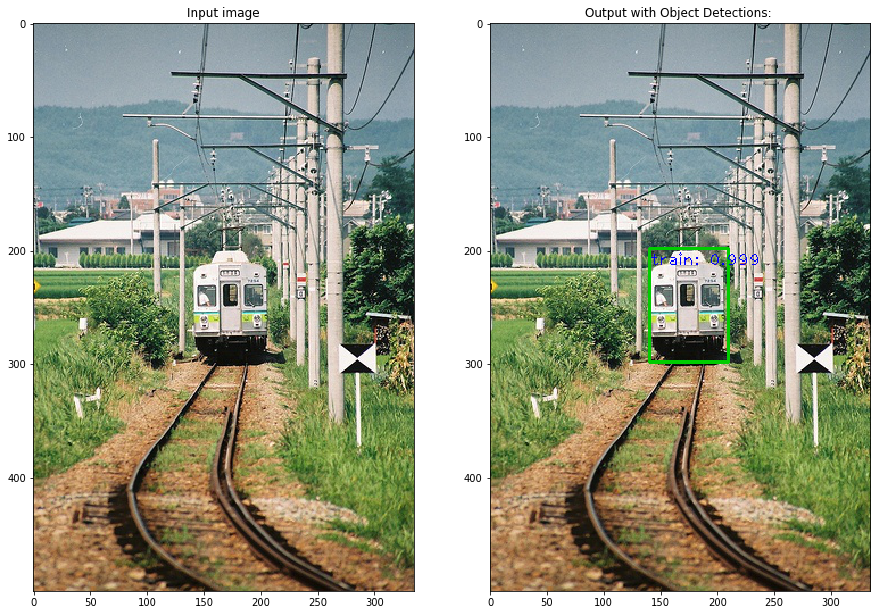

In [7]:
start = time.time()   
max_per_image = 100
thresh = 0.05
im_in = np.array(imread('./images/img2.jpg'))
im_out, cls_seen = process_image(im_in)
end = time.time()
print("Time taken for a single frame: ", end-start, "seconds")

fig, axes = plt.subplots(ncols=2, nrows=1, figsize=(15,16))
axes[0].imshow(im_in, cmap = 'Greys')
axes[0].set_title("Input image")
axes[1].imshow(im_out, cmap ='Greys')
axes[1].set_title("Output with Object Detections: ")
plt.show()
    

In [8]:
from moviepy.editor import ipython_display

#  To process videos for Faster RCNN
white_output = 'output.mp4'
clip1 = VideoFileClip("camera_1.mp4")
white_clip = clip1.fl_image(process_frame) 
%time white_clip.write_videofile(white_output, audio=False)
clip1.ipython_display(t=10)
white_clip.ipython_display(t=10)

In [9]:
def print_time(total_time, total_frames):
    
    print("Total time is: {} seconds".format(total_time))
    avgtime_per_frame = total_time/total_frames
    print("Frame rate is: {} fps".format(1/avgtime_per_frame))

    time_elapsed_mins = (total_time/60) - ((total_time/60) % 1)
    time_elapsed_secs = ((total_time/60)%1)*60

    print("Average computation time per frame: " + str(avgtime_per_frame))
    print("Completed. Total time for computation: " + str(time_elapsed_mins) + " minutes, " + str(time_elapsed_secs) + " seconds.")

In [10]:
sum_tt = 0
sum_fps = 0
for veh_cam in ["camera_1.mp4", "camera_2.mp4", "camera_5.mp4", "camera_6.mp4"]:
    total_time = 0
    total_frames = 0
    clip1 = VideoFileClip(veh_cam)
    
    cur_output = veh_cam.replace(".mp4", "_out.mp4")
    print("For {}".format(veh_cam))
    white_clip = clip1.fl_image(process_frame)
    white_clip.write_videofile(cur_output, audio=False)
    sum_tt +=total_time
    sum_fps += total_time/total_frames
    print_time(total_time, total_frames)

For camera_1.mp4
[MoviePy] >>>> Building video camera_1_out.mp4
[MoviePy] Writing video camera_1_out.mp4


100%|██████████| 4750/4750 [30:13<00:00,  2.69it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: camera_1_out.mp4 

Total time is: 581.614122868 seconds
Frame rate is: 8.16864620924 fps
Average computation time per frame: 0.122419306013
Completed. Total time for computation: 9.0 minutes, 41.6141228676 seconds.
For camera_2.mp4
[MoviePy] >>>> Building video camera_2_out.mp4
[MoviePy] Writing video camera_2_out.mp4


100%|█████████▉| 4902/4903 [31:27<00:00,  2.72it/s] 


[MoviePy] Done.
[MoviePy] >>>> Video ready: camera_2_out.mp4 

Total time is: 601.820349455 seconds
Frame rate is: 8.14694950817 fps
Average computation time per frame: 0.122745329279
Completed. Total time for computation: 10.0 minutes, 1.82034945488 seconds.
For camera_5.mp4
[MoviePy] >>>> Building video camera_5_out.mp4
[MoviePy] Writing video camera_5_out.mp4


100%|██████████| 4810/4810 [30:38<00:00,  2.64it/s] 


[MoviePy] Done.
[MoviePy] >>>> Video ready: camera_5_out.mp4 

Total time is: 589.093541861 seconds
Frame rate is: 8.1667844886 fps
Average computation time per frame: 0.122447213024
Completed. Total time for computation: 9.0 minutes, 49.0935418606 seconds.
For camera_6.mp4
[MoviePy] >>>> Building video camera_6_out.mp4
[MoviePy] Writing video camera_6_out.mp4


100%|██████████| 4819/4819 [30:31<00:00,  2.59it/s]  


[MoviePy] Done.
[MoviePy] >>>> Video ready: camera_6_out.mp4 

Total time is: 589.032903671 seconds
Frame rate is: 8.18290450323 fps
Average computation time per frame: 0.122205996612
Completed. Total time for computation: 9.0 minutes, 49.0329036713 seconds.


## Results

In [14]:
avg_tt = (sum_tt)/4;
avg_fps = (sum_fps)/4;

print("Average Processing rate: {} fps".format(avg_fps))
print("Average time taken: {} seconds".format(avg_tt))

time_elapsed_mins = (avg_tt/60) - ((avg_tt/60) % 1)
time_elapsed_secs = ((avg_tt/60)%1)*60

print("Average time for computation: " + str(time_elapsed_mins) + " minutes, " + str(time_elapsed_secs) + " seconds.")

Average Processing rate: 8.16632117731 fps
Average time taken: 590.390229464 seconds
Average time for computation: 9.0 minutes, 50.3902294638 seconds.


Frame from orginal video at t=225 s



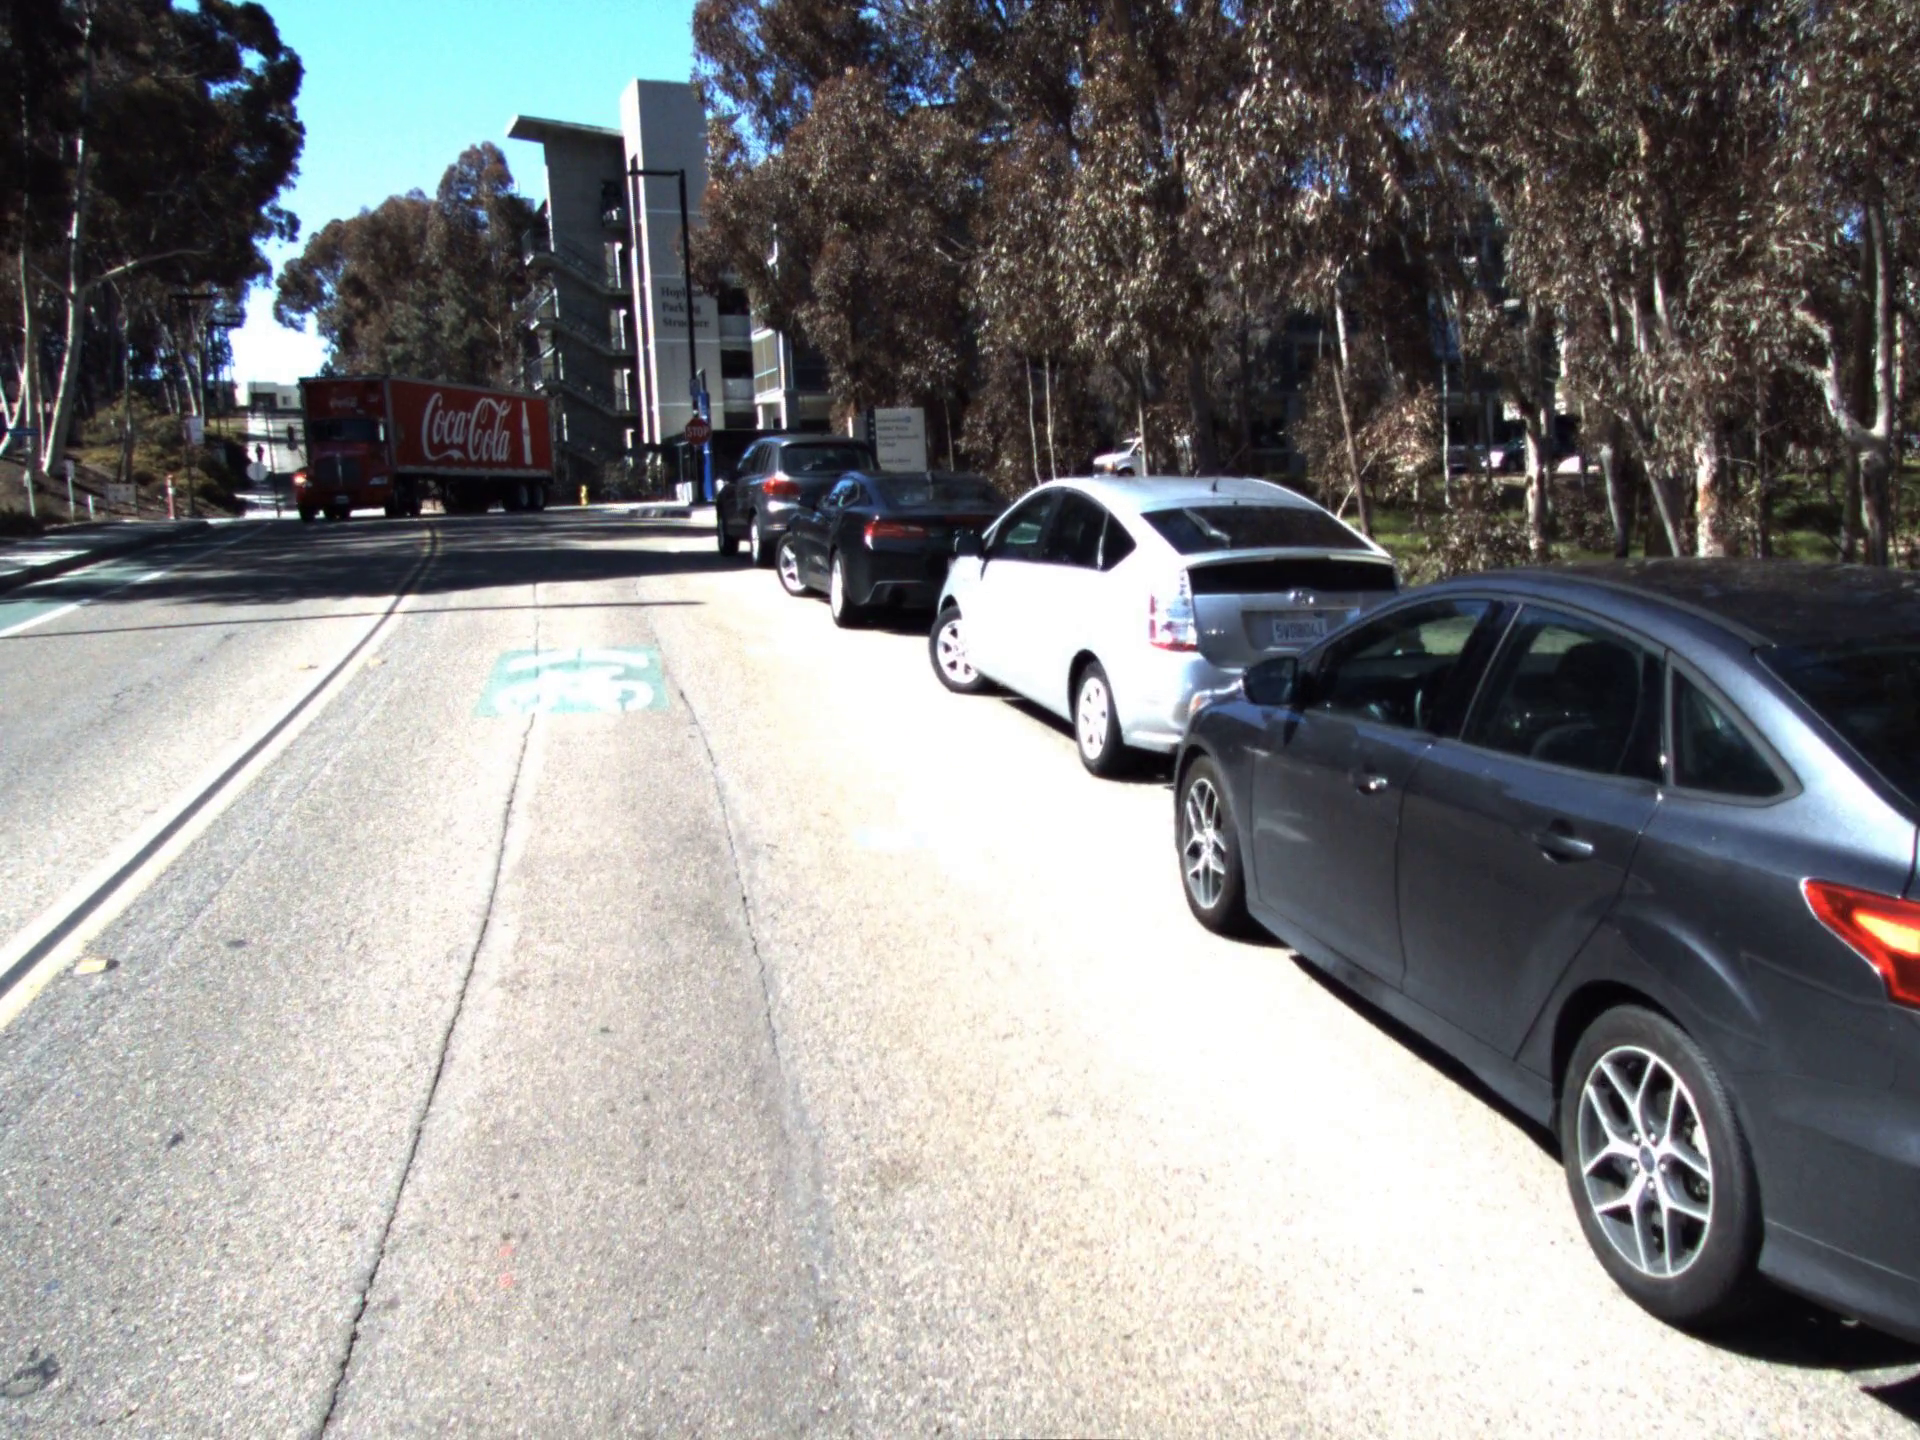

In [25]:
print("Frame from orginal video at t=225 s")
clip1.ipython_display(t=225, width=500)

Frame from processed video at t=225 s



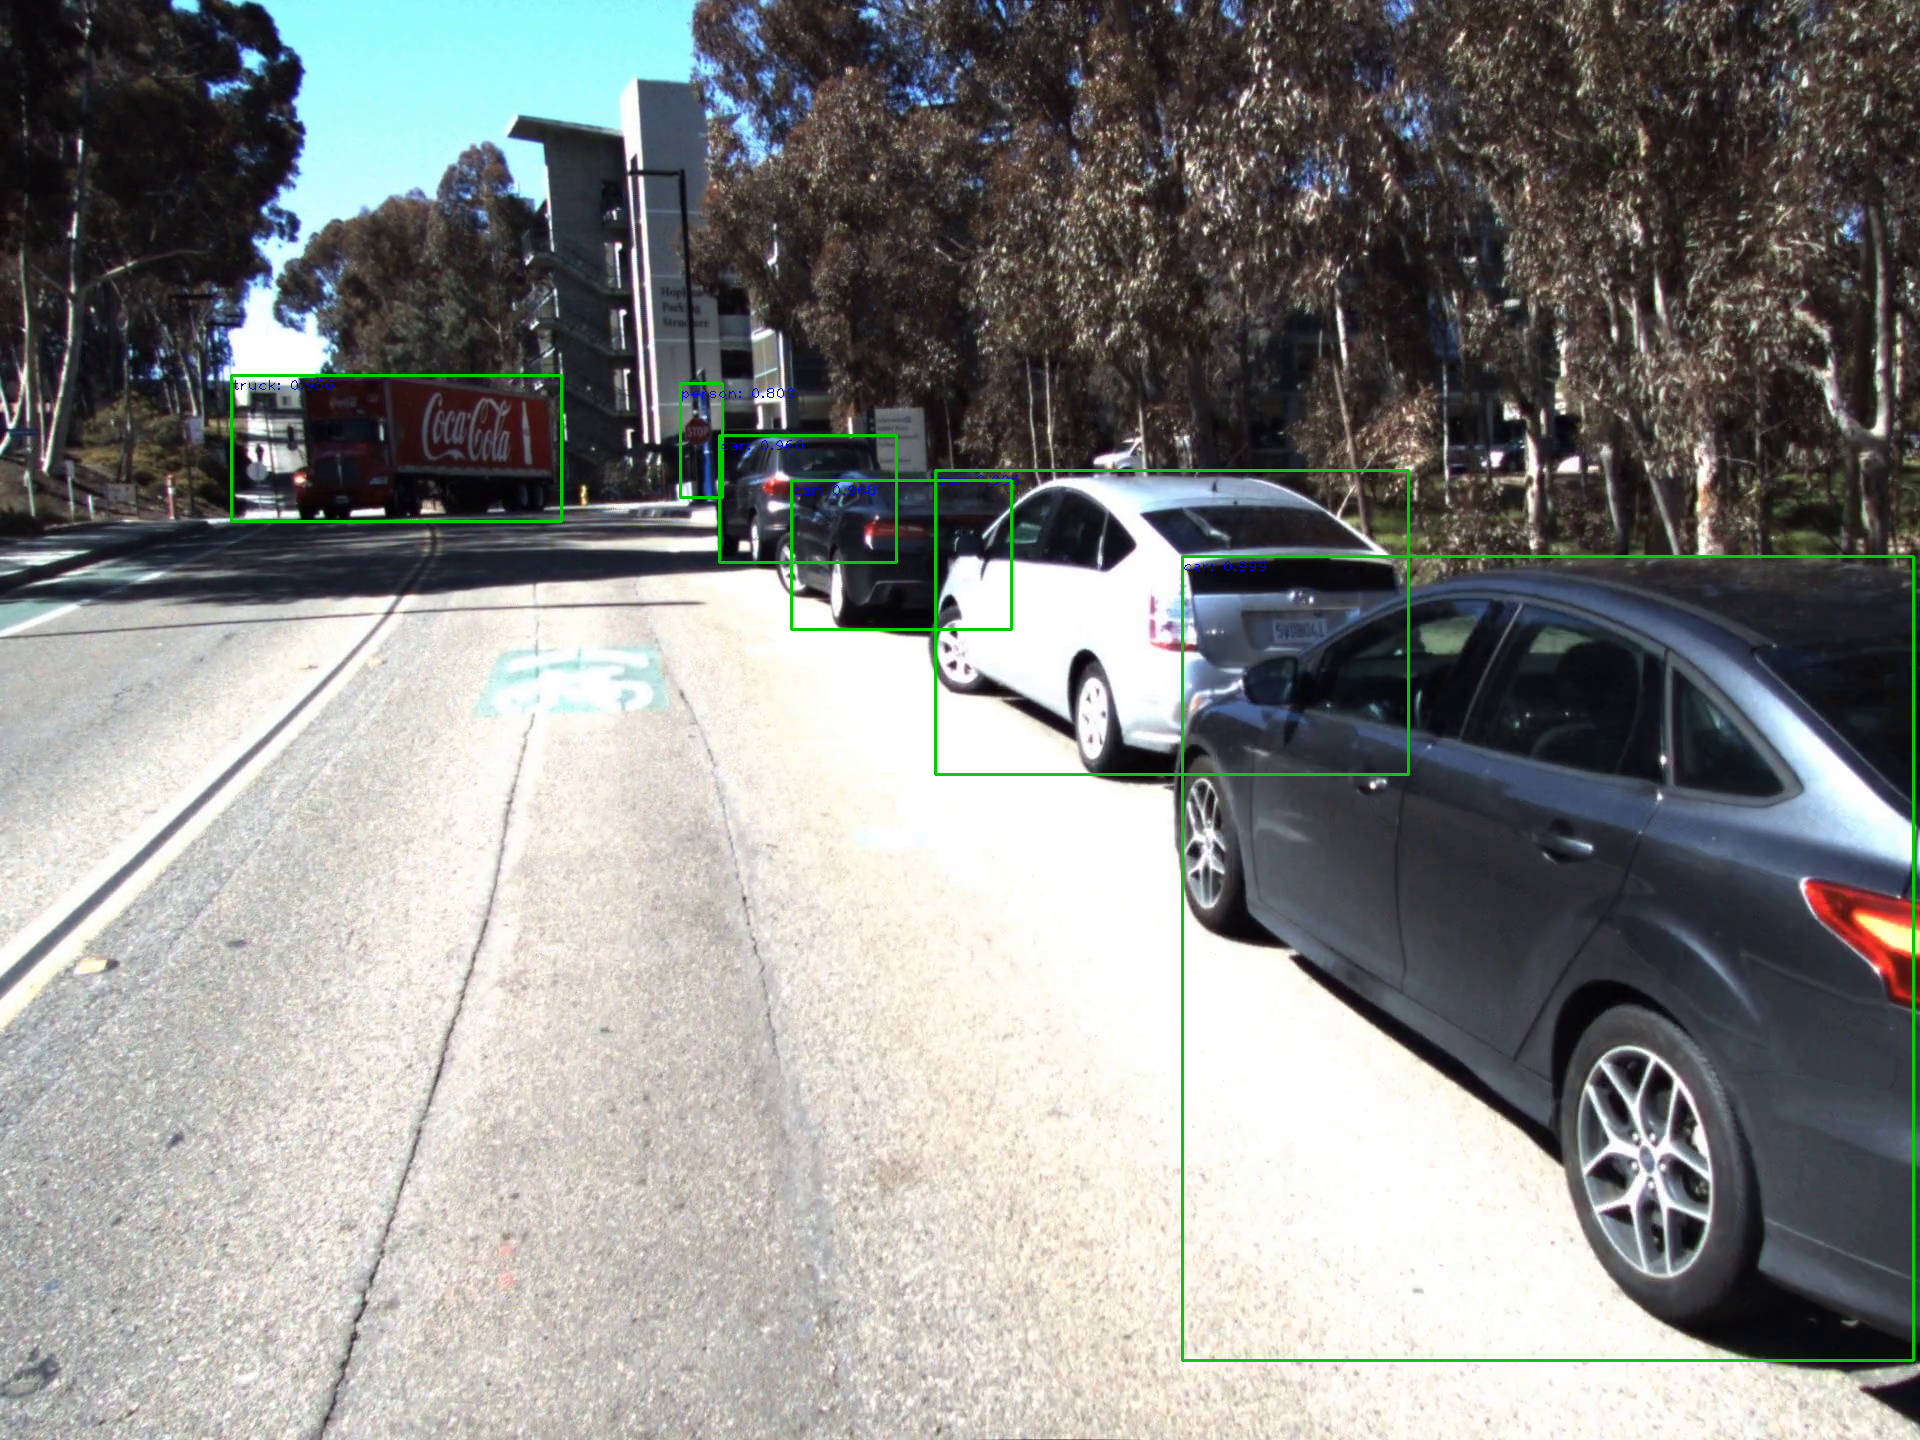

In [23]:
print("Frame from processed video at t=225 s")
white_clip.ipython_display(t=225, width=500, interactive=True)